In [1]:
#!pip install pyyaml h5py  # Required to save models in HDF5 format

ERROR: Invalid requirement: '#'


In [19]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.4.1


In [20]:
#There are several methods to process data using Google Colab. 
#One of them is to simply upload the data to your Google drive.
#I used the cats/dogs dataset that is available on Kaggle/ other places (just google cats/dogs dataset).

#Step 1:

#Mount your drive- run the code, go to the link, accept (make sure you're choosing the user that has the data on his drive if you have several accounts).
#from google.colab import drive
#drive.mount('/content/gdrive')

In [21]:
#Step 2:

#Change the working directory to make it easier to access the files.
#The way I organized it is as follows:
#Inside the Colab folder in the drive- CNN folder- Images folder- Train/Test folders- inside of each there are the images) 

import os
os.chdir("D:/DCBdogs-vs-cats1000")
os.getcwd() 

'D:\\DCBdogs-vs-cats1000'

In [22]:
#You can do anything you want with the data after step 2. I will continue here to show my steps to create the simple CNN model.

# Import libraries
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

#from scipy.misc import imresize, imsave

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold
from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, BatchNormalization
#Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
# use ImageDataGenerator to preprocess the data
from keras.preprocessing.image import ImageDataGenerator

In [23]:
#Giving labels to the images: 1 for dog, 0 for cat

path = "D:/DCBdogs-vs-cats1000/train/"
files = os.listdir(path)
categories = []

for filename in files:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    elif category == 'cat':
        categories.append(0)
    else: pass
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

<AxesSubplot:>

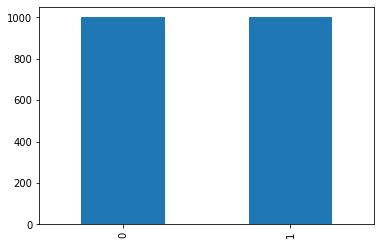

In [24]:
#Bar chart for the categories
df['category'].value_counts().plot.bar()

In [25]:
df


,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.101.jpg,0
...,...,...
1995,dog.995.jpg,1
1996,dog.996.jpg,1
1997,dog.997.jpg,1
1998,dog.998.jpg,1


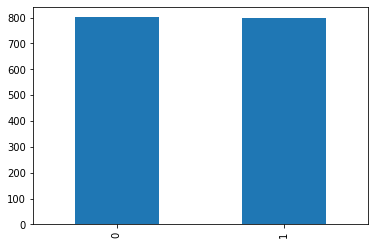

In [26]:
#Prepare Test and Train Data

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

total_train = train_df.shape[0] #the number of images in the training df
total_validate = validate_df.shape[0]  #the number of images in the validate df
batch_size=18

In [27]:
IMAGE_WIDTH=96
IMAGE_HEIGHT=96
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 45, 45, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)            

In [28]:
train_df["category"]=train_df["category"].astype(str)
validate_df["category"]=validate_df["category"].astype(str)

In [29]:
#Traning Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "D:/DCBdogs-vs-cats1000/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 1600 validated image filenames belonging to 2 classes.


In [30]:
#Validation Generator

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "D:/DCBdogs-vs-cats1000/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 400 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


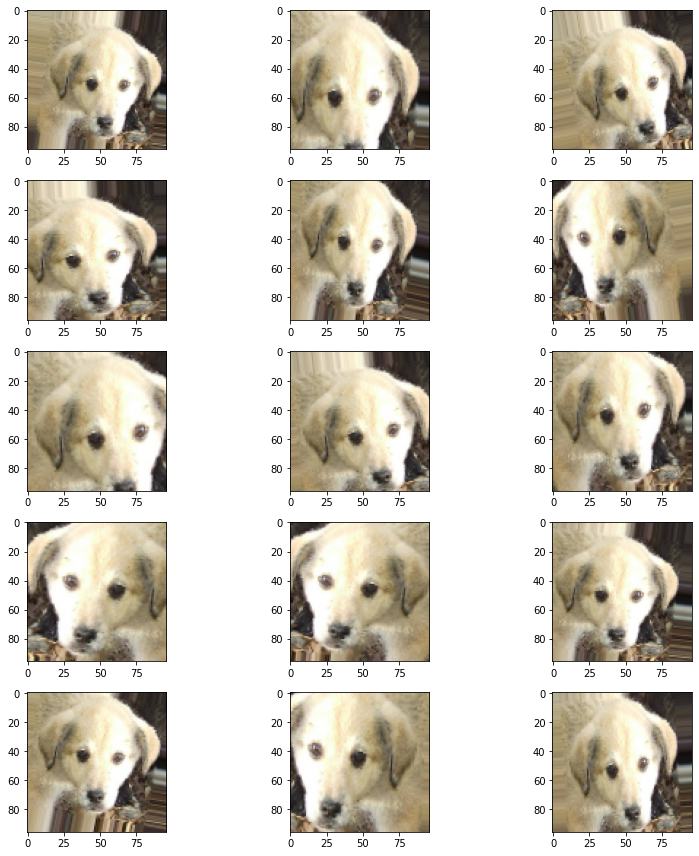

In [31]:
#See how the generator work

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "D:/DCBdogs-vs-cats1000/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    #class_mode='binary'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

<AxesSubplot:>

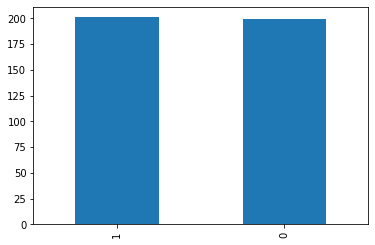

In [32]:
validate_df['category'].value_counts().plot.bar()

In [33]:
#Early Stopping 

earlystop = EarlyStopping(patience=10)

#Learning Rate Reduction

#We will reduce the learning rate when then accuracy is not increasing for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [36]:
from datetime import datetime

In [37]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.clock()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.clock() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()

In [38]:
timetaken = timecallback()


AttributeError: module 'time' has no attribute 'clock'

In [42]:
import time
#Fit Model

history = model.fit_generator(
    train_generator, 
    epochs=3,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/3
88/88 [==============================] - 31s 346ms/step - loss: 2.4365 - accuracy: 0.5790 - val_loss: 2.0958 - val_accuracy: 0.5177
Epoch 2/3
88/88 [==============================] - 30s 343ms/step - loss: 0.7347 - accuracy: 0.5860 - val_loss: 2.2913 - val_accuracy: 0.5379
Epoch 3/3
88/88 [==============================] - 30s 342ms/step - loss: 0.6750 - accuracy: 0.6144 - val_loss: 2.9544 - val_accuracy: 0.5000
Total time:  214.82794761657715 seconds


In [46]:
#Save Model (if you're happy with it)
# Save the weights
model.save_weights('model_weights_29.30.2020.h5')
model.save('dog_at.h5')# i have inserted this code



In [39]:
import time

start = time.time()
model.fit() # Training statement
print("Total time: ", time.time() - start, "seconds")

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>

In [47]:
# Downloading in local disk
#from google.colab import files
#files.download("model_weights.h5")

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [48]:
#Virtualize Training

#fig, ax = plt.subplots(2,1)
#ax[0].plot(history.history['loss'], color='b', label="Training loss")
#ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
#legend = ax[0].legend(loc='best', shadow=True)

#ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
#ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
#legend = ax[1].legend(loc='best', shadow=True)

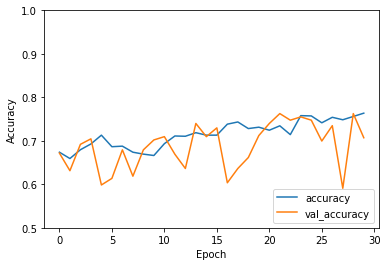

In [49]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')

In [54]:
epochs=5
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']


In [55]:
loss=history.history['loss']
val_loss=history.history['val_loss']

In [56]:
epochs_range=range(epochs)

ValueError: x and y must have same first dimension, but have shapes (5,) and (30,)

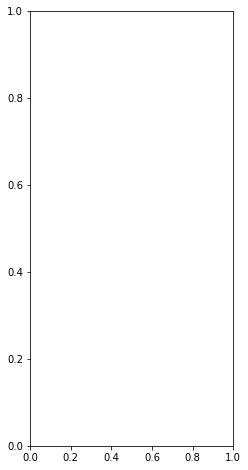

In [58]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Trainig Accuracy')
plt.plot(epochs_range, val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and validattion Accuracy')

ValueError: x and y must have same first dimension, but have shapes (5,) and (30,)

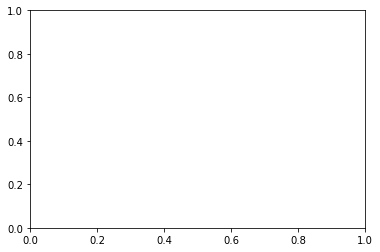

In [80]:
#plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
import cv2
def image_resizing(img_file):
  img_as_array=img_file
  #resized=cv2.resize(img_as_array),(img_width,img_height)
  resized=cv2.resize(img,(96,96))
  an_img=resized.reshape((1,)+resized.shape)
  return an_img


In [76]:
from  PIL import Image
img=np.asarray(Image.open('D:/DCBdogs-vs-cats1000/test/098.jpeg'))
img_rz=image_resizing(img)
img_rz.shape

(1, 96, 96, 3)

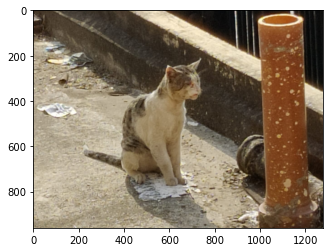

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)


In [78]:
predictions=model.predict(img_rz)
score=predictions[0]
score


array([1.], dtype=float32)

In [79]:
print(
    "This image is %.2f percent cat %.2f percent dog."
    %(100*(1-score),100*score)
    
)

This image is 0.00 percent cat 100.00 percent dog.
